In [1]:
%pylab inline
rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
np.random.seed(10)

# ABC PMC on a 2D gaussian example

In this example we're looking at a dataset that has been drawn from a 2D gaussian distribution. We're going to assume that we don't have a proper likelihood but that we know the covariance matrix $\Sigma$ of the distribution. Using the ABC PMC algorithm we will approximate the posterior of the distribtion of the mean values.

First we generate a new dataset by drawing random variables from a mulitvariate gaussian around mean=[1.1, 1.5]. This is going to be our observed data set

In [3]:
samples_size = 1000
sigma = np.ones((2,2)) * 0.25
means = [1.1, 1.5]

data = np.random.multivariate_normal(means, sigma, samples_size)

Then we need to define our model/simulation. In this case this is simple: we draw again random variables from a multivariate gaussian distribution using the given mean and the sigma from above

In [4]:
def create_new_sample(theta):
    return np.random.multivariate_normal(theta, sigma, samples_size)

Next, we need to define a distance measure. We will use the sum of the absolute differences of the means of the simulated and the observed data

In [5]:
def dist_measure(x, y):
    return np.sum(np.abs(np.mean(x, axis=0) - np.mean(y, axis=0)))

### Verification

To verify if everything works and to see the effect of the random samples in the simulation we compute the distance for 1000 simulations at the true mean values

In [6]:
distances = [dist_measure(data, create_new_sample(means)) for _ in range(1000)]

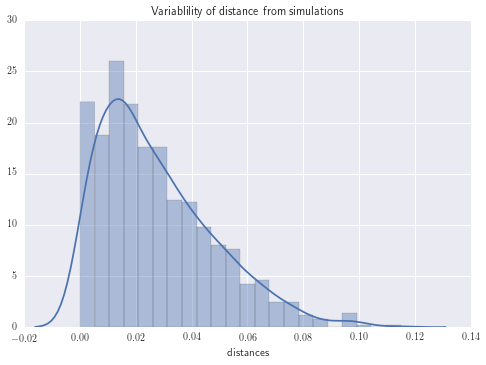

In [7]:
sns.distplot(distances, axlabel="distances", )
title("Variablility of distance from simulations")

### Setup

Now we're going to set up the ABC PMC sampling

In [8]:
import abcpmc

As a prior we're going to use a gaussian prior using our best guess about the distribution of the means. 

In [9]:
prior = abcpmc.GaussianPrior(mu=[1.0, 1.0], sigma=np.eye(2) * 0.5)

As threshold $\epsilon$ we're going to use the $\alpha^{th}$ percentile of the sorted distances of the particles of the current iteration. The simplest way to do this is to define a constant $\epsilon$ and iteratively adapt the theshold. As starting value we're going to define a sufficiently high value so that the acceptance ratio is reasonable and we will sample for T iterations

In [10]:
alpha = 75
T = 20
eps_start = 1.0
eps = abcpmc.ConstEps(T, eps_start)

Finally, we create an instance of your sampler. We want to use 500 particles and the functions we defined above. Additionally we're going to make use of the built-in parallelization and use 7 cores for the sampling

In [11]:
sampler = abcpmc.Sampler(N=100, Y=data, postfn=create_new_sample, dist=dist_measure, threads=7)

Optionally, we can customize the proposal creation. Here we're going to use a "Optimal Local Covariance Matrix"-kernel (OLCM) as proposed by (Fillipi et al. 2012). This has shown to yield a high acceptance ratio togheter with a faster decrease of the thresold.

In [12]:
sampler.particle_proposal_cls = abcpmc.OLCMParticleProposal

### Sampling

Now we're ready to sample. All we need to do is to iterate over the yielded values of your sampler instance. The sample function returns a namedtuple per iteration that contains all the information that we're interestend in

In [13]:
def launch():
    sampler = abcpmc.Sampler(N=500, Y=data, postfn=create_new_sample, dist=dist_measure, threads=7)
    eps = abcpmc.ConstEps(T, eps_start)

    pools = []
    for pool in sampler.sample(prior, eps):
        print("T: {0}, eps: {1:>.4f}, ratio: {2:>.4f}".format(pool.t, eps(pool.eps), pool.ratio))

        for i, (mean, std) in enumerate(zip(np.mean(pool.thetas, axis=0), np.std(pool.thetas, axis=0))):
            print(u"    theta[{0}]: {1:>.4f} \u00B1 {2:>.4f}".format(i, mean,std))

        eps.eps = np.percentile(pool.dists, alpha) # reduce eps value
        pools.append(pool)
    sampler.close()
    return pools


In [14]:
import time
t0 = time.time()
pools = launch()
print "took", (time.time() - t0)

T: 0, eps: 1.0000, ratio: 0.3861
    theta[0]: 1.0924 ± 0.3679
    theta[1]: 1.3526 ± 0.3633
T: 1, eps: 0.8517, ratio: 0.4115
    theta[0]: 1.1362 ± 0.3337
    theta[1]: 1.4226 ± 0.3190
T: 2, eps: 0.7795, ratio: 0.4621
    theta[0]: 1.0840 ± 0.3040
    theta[1]: 1.4925 ± 0.3184
T: 3, eps: 0.6687, ratio: 0.3912
    theta[0]: 1.0740 ± 0.2580
    theta[1]: 1.4881 ± 0.2823
T: 4, eps: 0.5757, ratio: 0.3618
    theta[0]: 1.1228 ± 0.2252
    theta[1]: 1.4627 ± 0.2240
T: 5, eps: 0.5033, ratio: 0.4143
    theta[0]: 1.1037 ± 0.1987
    theta[1]: 1.4907 ± 0.1806
T: 6, eps: 0.4190, ratio: 0.3831
    theta[0]: 1.0635 ± 0.1638
    theta[1]: 1.5185 ± 0.1687
T: 7, eps: 0.3591, ratio: 0.3584
    theta[0]: 1.0901 ± 0.1529
    theta[1]: 1.4898 ± 0.1280
T: 8, eps: 0.3037, ratio: 0.3211
    theta[0]: 1.0974 ± 0.1098
    theta[1]: 1.5027 ± 0.1136
T: 9, eps: 0.2501, ratio: 0.3257
    theta[0]: 1.1000 ± 0.0987
    theta[1]: 1.5008 ± 0.0968
T: 10, eps: 0.2072, ratio: 0.3189
    theta[0]: 1.1193 ± 0.0776
    th

### Postprocessing

How did the sampled values evolve over the iterations? As the threshold is decreasing we expect the errors to shrink while the means converge to the true means.

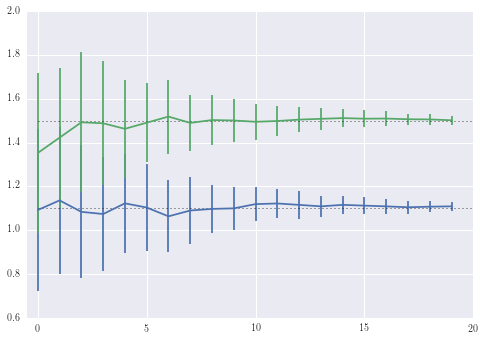

In [15]:
samples = np.array([pool.thetas for pool in pools])
for i in range(samples.shape[2]):
    errorbar(range(T), np.mean(samples[:, :, i], axis=1), np.std(samples[:, :, i], axis=1))
hlines(means, 0, T, linestyle="dotted", linewidth=0.7)
_ = xlim([-.5, T])

How does the distribution of the distances look like after we have approximated the posterior? If we're close to the true posterior we expect to have a high bin count around the values we've found in the earlier distribution plot

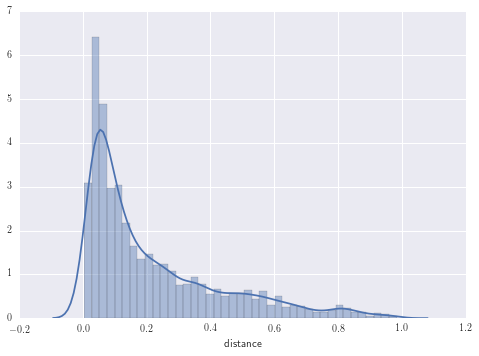

In [16]:
distances = np.array([pool.dists for pool in pools]).flatten()
sns.distplot(distances, axlabel="distance")

How did our $\epsilon$ values behave over the iterations? Using the $\alpha^{th}$ percentile causes the threshold to decrease relatively fast in the beginning and to plateau later on

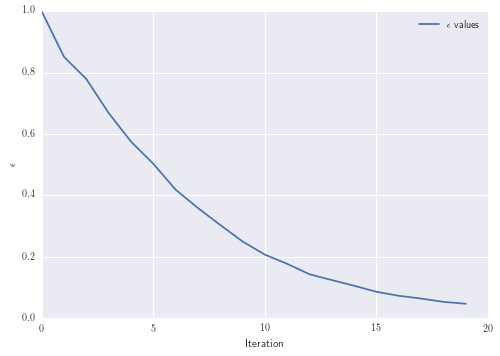

In [17]:
eps_values = np.array([pool.eps for pool in pools])
plot(eps_values, label=r"$\epsilon$ values")
xlabel("Iteration")
ylabel(r"$\epsilon$")
legend(loc="best")

What about the acceptance ratio? ABC PMC with the OLCM kernel gives us a relatively high acceptance ratio.

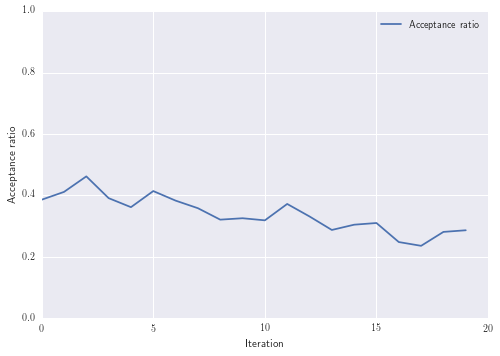

In [18]:
acc_ratios = np.array([pool.ratio for pool in pools])
plot(acc_ratios, label="Acceptance ratio")
ylim([0, 1])
xlabel("Iteration")
ylabel("Acceptance ratio")
legend(loc="best")

Finally what does our posterior look like? For the visualization we're using triangle.py (https://github.com/dfm/triangle.py)

mean: 1.1091 ± 0.0195
mean: 1.5018 ± 0.0206


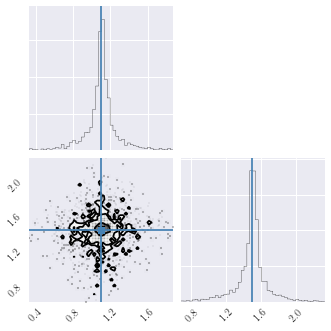

In [19]:
import triangle
samples = np.vstack([pool.thetas for pool in pools])
fig = triangle.corner(samples, truths= means)

for mean, std in zip(np.mean(pool.thetas, axis=0), np.std(pool.thetas, axis=0)):
    print(u"mean: {0:>.4f} \u00B1 {1:>.4f}".format(mean,std))

Omitting the first couple of iterations..

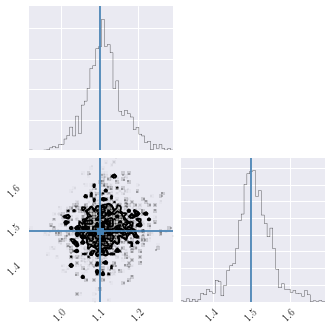

In [20]:
samples = np.vstack([pool.thetas for pool in pools[-10:]])
fig = triangle.corner(samples, truths= means)